# Calibration of a 2 theta arm with a Pilatus 100k detector

The aim of this document is to explain how to use pyFAI.goniometer for calibrating the position of the detector from the goniometer encoders.

Those data have been acquired at ROBL (ESRF-BM20 German CRG) in winter 2017 by Christoph Henning using a Pilatus 100k detector and LaB6 as calibrant. One hundred and twenty one images have been acquired with the detector moving between 5 and 65 degree with a step size of half a degree. The motor position is registered in the filename.

A prior manual calibration (using pyFAI-calib) has been performed on four images locate at 31.5, 33.5, 35 and 35.5 degrees. Those images were the first with two rings. The control points extrated during this initial calibration has been used as a starting point for this calibration. Then more images have been added to make the model more robust.

The raw data files are available at: http://www.silx.org/pub/pyFAI/gonio/Pilatus-100k-LaB6/

## Initialization and loading of the libraries

Initialization of the plotting library, matplotlib, to be used with the jupyter notebook

In [1]:
%pylab nbagg

import time, pyFAI
start_time = time.time()
print("Using pyFAI version", pyFAI.version)

Populating the interactive namespace from numpy and matplotlib


/mntdirect/_scisoft/users/jupyter/jupy35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using pyFAI version 0.15.0-beta2


In [2]:
#Download all images

import os
from silx.resources import ExternalResources

#Nota: Comment when outside ESRF
os.environ["http_proxy"] = "http://proxy.esrf.fr:3128"

downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/testimages", "PYFAI_DATA")
all_files = downloader.getdir("LaB6_gonio_BM20.tar.bz2")
print([os.path.basename(i) for i in all_files])


['LaB6_gonio_BM20', 'del_45.0_0001p.cbf', 'del_08.5_0001p.cbf', 'del_20.5_0001p.cbf', 'minimum-mask.edf', 'del_09.0_0001p.cbf', 'del_53.0_0001p.cbf', 'del_60.0_0001p.cbf', 'del_63.5_0001p.cbf', 'del_56.5_0001p.cbf', 'del_12.5_0001p.cbf', 'del_53.5_0001p.cbf', 'del_42.5_0001p.cbf', 'del_16.5_0001p.cbf', 'del_05.5_0001p.cbf', 'del_47.0_0001p.cbf', 'del_39.0_0001p.cbf', 'del_47.5_0001p.cbf', 'del_57.0_0001p.cbf', 'del_35.5_0001p.poni', 'del_07.5_0001p.cbf', 'del_41.5_0001p.cbf', 'del_51.0_0001p.cbf', 'del_33.0_0001p.cbf', 'del_22.0_0001p.cbf', 'del_43.5_0001p.cbf', 'del_64.5_0001p.cbf', 'del_35.0_0001p.cbf', 'del_13.5_0001p.cbf', 'del_08.0_0001p.cbf', 'del_29.0_0001p.cbf', 'del_45.5_0001p.cbf', 'del_63.0_0001p.cbf', 'del_61.5_0001p.cbf', 'del_31.5_0001p.npt', 'del_11.0_0001p.cbf', 'del_46.5_0001p.cbf', 'del_11.5_0001p.cbf', 'del_56.0_0001p.cbf', 'del_18.0_0001p.cbf', 'del_06.5_0001p.cbf', 'del_46.0_0001p.cbf', 'del_58.5_0001p.cbf', 'del_35.5_0001p.npt', 'del_30.0_0001p.cbf', 'del_15.5_000

In [3]:
#Loading of a few libraries

import os
import random
import fabio
import pyFAI
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

## Display of an image and its headers

List of images: /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_05.0_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_05.5_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_06.0_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_06.5_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_07.0_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_07.5_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_08.0_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_08.5_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_09.0_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_09.5_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_10.0_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_10.5_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_11.0_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_11.5_0001p.cbf, /tmp/pyFAI_testdata_kieffer/LaB6_gonio_BM20/del_12.0_0001p.cbf, /tmp/pyFAI_testdata_kief

<IPython.core.display.Javascript object>


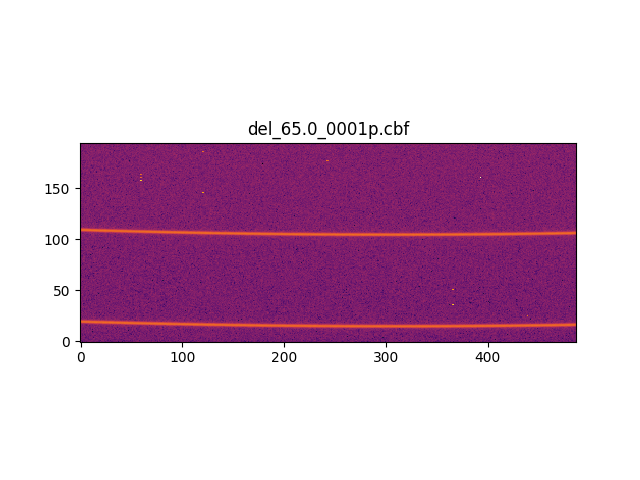

In [4]:
#loading of the list of files, and display of the last one with its headers

image_files = [i for i in all_files if i.endswith(".cbf")]
image_files.sort()
print("List of images: " + ", ".join(image_files) + "." + os.linesep)
fimg = fabio.open(image_files[-1])

print("Image headers:")
for key, value in  fimg.header.items():
    print("%s: %s"%(key,value))
    
jupyter.display(fimg.data, label=os.path.basename(fimg.filename))

## Definition of the geometry transformation

This is the most difficult part to understand.

The next cell defines 2 functions, one for transforming the geometry and the other one to read the goniometer angle from the metadata

In [5]:
#Definition of the goniometer translation function:
# The detector rotates vertically, around the horizontal axis, i.e. rot2

goniotrans = GeometryTransformation(param_names = ["dist", "poni1", "poni2", "rot1",
                                                   "rot2_offset", "rot2_scale"],
                                    dist_expr="dist", 
                                    poni1_expr="poni1",
                                    poni2_expr="poni2", 
                                    rot1_expr="rot1", 
                                    rot2_expr="rot2_scale * pos + rot2_offset", 
                                    rot3_expr="0.0")


#Definition of the function reading the goniometer angle from the filename of the image.

def get_angle(basename):
    """Takes the basename (like del_65.0_0001p ) and returns the angle of the detector"""
    return float(os.path.basename((basename.split("_")[1])))

basename = os.path.basename(fimg.filename)
print('filename', basename, "angle:",get_angle(basename))

filename del_65.0_0001p.cbf angle: 65.0


In [6]:
#Definition of the detector, its mask, the calibrant
mask_files = [i for i in all_files if i.endswith("-mask.edf")]
mask = numpy.logical_or(fabio.open(mask_files[0]).data, fabio.open(mask_files[1]).data)
pilatus = pyFAI.detector_factory("Pilatus100k")
pilatus.mask = mask
    
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
wavelength = 7.7490120575e-11
LaB6.wavelength = wavelength

In [7]:
#Definition of the geometry refinement: the parameter order is the same as the param_names

param = {"dist":0.8, 
         "poni1":0.02, 
         "poni2":0.04, 
         "rot1":0,
         "rot2_offset":0,
         "rot2_scale": numpy.pi/180. # rot2 is in radians, while the motor position is in degrees
        }
#Defines the bounds for some variables
bounds = {"dist": (0.79, 0.81), 
          "rot1": (-0.01, 0.01),
          "rot2_offset": (-0.01, 0.01),
          "rot2_scale": (numpy.pi/180., numpy.pi/180.) #strict bounds on the scale: we expect the gonio to be precise
         }
gonioref = GoniometerRefinement(param, #initial guess
                                bounds=bounds,
                                pos_function=get_angle,
                                trans_function=goniotrans,
                                detector=pilatus, wavelength=wavelength)
print("Empty refinement object:")
print(gonioref)

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .


In [8]:
#Let's populate the goniometer refinement object with all control point files:

ponis = [i for i in all_files if i.endswith(".poni")]
ponis.sort()
for fn in ponis:
    base = os.path.splitext(fn)[0]
    basename = os.path.basename(base)
    fimg = fabio.open(base + ".cbf")
    sg =gonioref.new_geometry(basename, image=fimg.data, metadata=basename, control_points=base+".npt",
                              geometry=fn, calibrant=LaB6)
    print(sg.label, "Angle:", sg.get_position())
    print(sg.geometry_refinement)
    print()
    

print("Filled refinement object:")
print(gonioref)


del_31.5_0001p Angle: 31.5
Detector Pilatus 100k	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 7.749012e-11m
SampleDetDist= 8.058209e-01m	PONI= 5.700310e-03, 4.599931e-02m	rot1=-0.000000  rot2= 0.560707  rot3= -0.000065 rad
DirectBeamDist= 951.518mm	Center: x=267.438, y=2975.017 pix	Tilt=32.126 deg  tiltPlanRotation= 90.000 deg

del_33.5_0001p Angle: 33.5
Detector Pilatus 100k	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 7.749012e-11m
SampleDetDist= 8.061475e-01m	PONI= 1.998418e-02, 4.623309e-02m	rot1=0.000061  rot2= 0.577898  rot3= -0.000000 rad
DirectBeamDist= 962.435mm	Center: x=268.511, y=3172.837 pix	Tilt=33.111 deg  tiltPlanRotation= 90.005 deg

del_35.0_0001p Angle: 35.0
Detector Pilatus 100k	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 7.749012e-11m
SampleDetDist= 8.053432e-01m	PONI= 5.551240e-03, 4.624546e-02m	rot1=-0.000016  rot2= 0.622009  rot3= 0.000012 rad
DirectBeamDist= 990.936mm	Center: x=268.944, y=3389.181 pix	Tilt=35.638 deg  tiltPlanRotation= 89.999 deg

del_35

<IPython.core.display.Javascript object>


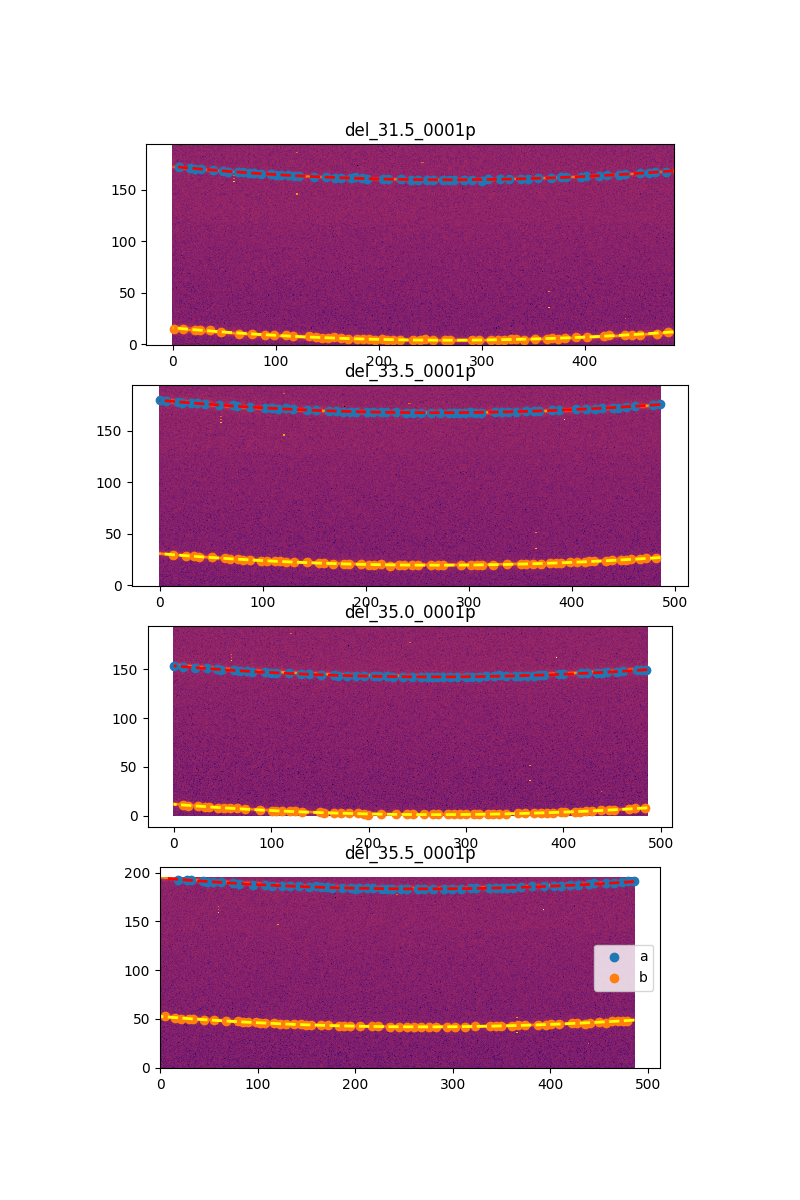

In [9]:
#Display all images with associated calibration:
nimg = len(gonioref.single_geometries)
fig,ax = subplots(nimg, 1, figsize=(8,nimg*3))
for i, sg in enumerate(gonioref.single_geometries.values()):
    jupyter.display(sg=sg, ax=ax[i])

In [10]:
# Initial refinement of the goniometer model with 5 dof
gonioref.refine2()

Cost function before refinement: 4.676280279481871e-05
[0.8        0.02       0.04       0.         0.         0.01745329]
     fun: 3.4745458906298305e-09
     jac: array([ 1.55798347e-08,  6.20440474e-08, -8.86844706e-09,  9.38192904e-09,
        4.54171479e-08,  5.30001824e-06])
 message: 'Optimization terminated successfully.'
    nfev: 145
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 0.80587963,  0.01626972,  0.04374852, -0.00299843, -0.00217847,
        0.01745329])
Cost function after refinement: 3.4745458906298305e-09
GonioParam(dist=0.8058796325498109, poni1=0.016269720089887214, poni2=0.04374852459791066, rot1=-0.00299843026796996, rot2_offset=-0.002178469918866194, rot2_scale=0.017453292519943295)
maxdelta on: dist (0) 0.8 --> 0.8058796325498109


array([ 0.80587963,  0.01626972,  0.04374852, -0.00299843, -0.00217847,
        0.01745329])

In [11]:
# This function adds new images to the pool of data used for the refinement.
# A set of new control points are extractred and a refinement step is performed at each iteration
# The last image of the serie is displayed 

def optimize_with_new_images(list_images, pts_per_deg=1):
    sg = None
    for fname in list_images:
        print()
        basename = os.path.basename(fname)
        base = os.path.splitext(basename)[0]
        fimg = fabio.open(fname)
        if base in gonioref.single_geometries:
            continue
        print(base)
        sg = gonioref.new_geometry(base, image=fimg.data, metadata=base,
                                   calibrant=LaB6)
        print(sg.extract_cp(pts_per_deg=pts_per_deg))
    print("*"*50)
    gonioref.refine2()
    if sg: 
        sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
        jupyter.display(sg=sg)



del_38.0_0001p
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
# c ring 10: 30 points

del_37.0_0001p
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
# d ring 9: 36 points
# e ring 10: 30 points

del_39.0_0001p
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
# f ring 10: 15 points
# g ring 11: 30 points


del_38.5_0001p
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
# h ring 10: 30 points
# i ring 11: 30 points

del_34.0_0001p
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
# j ring 8: 36

<IPython.core.display.Javascript object>


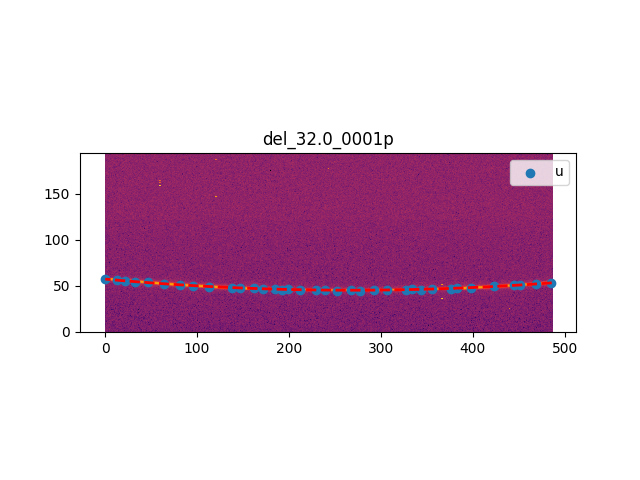

In [12]:
# Append all other images bewteen 30 and 40 degrees

images_30_40 = [i for i in all_files if ("del_3" in i and i.endswith("0001p.cbf"))]
random.shuffle(images_30_40)
optimize_with_new_images(images_30_40, pts_per_deg=3)


del_49.5_0001p
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
# v ring 17: 8 points
# w ring 18: 3 points

del_41.0_0001p
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
# x ring 12: 10 points

del_62.0_0001p
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
# y ring 25: 8 points


del_46.5_0001p
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
# z ring 14: 7 points
#aa ring 15: 10 points



del_10.0_0001p
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#ab ring 0: 29 points

del_20.5_0001p


ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#bu ring 3: 17 points

del_60.5_0001p
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
#bv ring 24: 8 points
#bw ring 25: 8 points



del_48.5_0001p
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
#bx ring 16: 9 points
#by ring 17: 9 points

del_46.0_0001p
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
#bz ring 14: 10 points
#ca ring 15: 10 points

del_13.0_0001p
ControlPoints instance containing 0 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 0 groups of points:

del_44.0_0001p
ControlPoints ins

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#dp ring 16: 9 points

del_28.5_0001p
ControlPoints instance containing 0 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 0 groups of points:

del_09.0_0001p
ControlPoints instance containing 0 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 0 groups of points:

del_23.0_0001p
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#dq ring 4: 11 points

del_61.0_0001p
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
#dr ring 24: 8 points
#ds ring 25: 8 points

del_12.5_0001p
ControlPoints instance containing 0 group of point:
LaB6 Calibrant with 97 reflections 

<IPython.core.display.Javascript object>


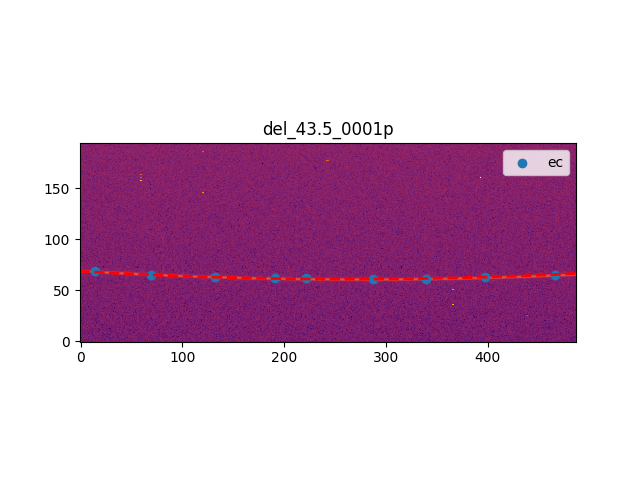

In [13]:
# Append all other images

all_images = [i for i in all_files if i.endswith(".cbf")]
random.shuffle(all_images)
optimize_with_new_images(all_images)

First & last rings
Total number of images: 121


<IPython.core.display.Javascript object>


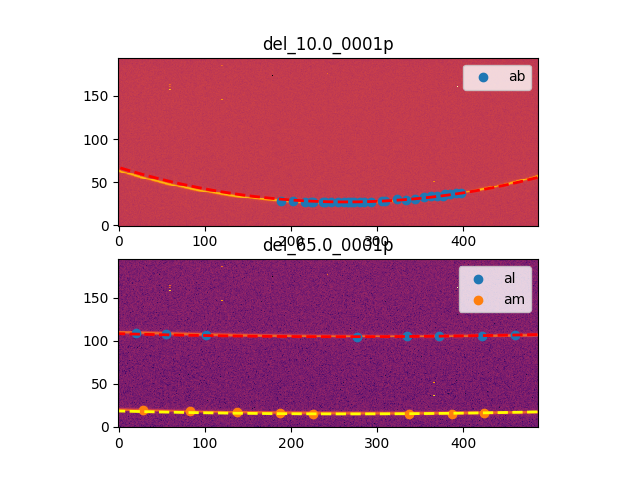

In [14]:
# Check the calibration of the first and the last image with rings

print("First & last rings")

print("Total number of images:", len(gonioref.single_geometries) )

fig = plt.figure()
for idx,lbl in enumerate(["del_10.0_0001p", "del_65.0_0001p"]):
    sg = gonioref.single_geometries[lbl]
    if sg.control_points.get_labels():
        sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
    jupyter.display(sg=sg, ax=fig.add_subplot(2, 1, idx+1))

In [15]:
# Final pass of refinement with all constrains removed, very fine refinement

gonioref.bounds = None
gonioref.refine2("slsqp", eps=1e-13, maxiter=10000, ftol=1e-12)

Cost function before refinement: 1.2457867804583228e-08
[ 0.80588807  0.01627369  0.04329277 -0.00263014 -0.002175    0.01745329]
     fun: 1.0840209527662121e-08
     jac: array([ 4.62724835e-08, -1.16963339e-08,  5.90127193e-07, -4.83917202e-07,
       -3.87120527e-09, -1.39958960e-08])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.80588823,  0.01622094,  0.04329203, -0.00262952, -0.00221753,
        0.01745631])
Cost function after refinement: 1.0840209527662121e-08
GonioParam(dist=0.8058882322872523, poni1=0.016220937406978945, poni2=0.04329203358397654, rot1=-0.0026295185046565014, rot2_offset=-0.002217531057579051, rot2_scale=0.017456308042413993)
maxdelta on: poni1 (1) 0.01627369140392072 --> 0.016220937406978945


array([ 0.80588823,  0.01622094,  0.04329203, -0.00262952, -0.00221753,
        0.01745631])

In [16]:
#Create a MultiGeometry integrator from the refined geometry:

angles = []
images = []
for sg in gonioref.single_geometries.values():
    angles.append(sg.get_position())
    images.append(sg.image)
    
multigeo = gonioref.get_mg(angles)
multigeo.radial_range=(4, 66)
print(multigeo)

MultiGeometry integrator with 121 geometries on (4, 66) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


In [17]:
# Calculate the optimal number of point for integration
over = 1
npt = int(over * numpy.deg2rad(max(multigeo.radial_range) - min(multigeo.radial_range)) / 
          numpy.arctan2(pilatus.pixel1, gonioref.nt_param(*gonioref.param).dist))
print("Number of bins: %s"%npt)

Number of bins: 5070


<IPython.core.display.Javascript object>


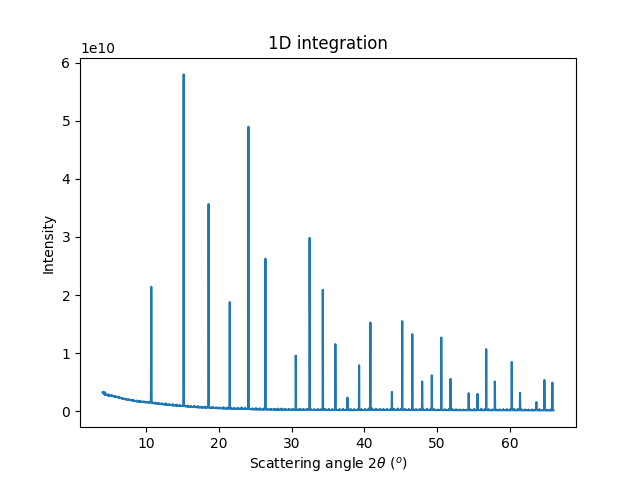

In [18]:
# Integrate the whole set of images in a single run:

res = multigeo.integrate1d(images, npt)
jupyter.plot1d(res)


In [19]:
# Save the goniometer configuration with 1 angle

gonioref.save("ROBL_v1.json")

In [20]:
#Can the refinement be improved by freeing another degree of freedom ? what about rot1 ?

goniotrans2 = GeometryTransformation(param_names = ["dist", "poni1", "poni2", 
                                                    "rot1", "rot1_scale",
                                                    "rot2_offset", "rot2_scale"],
                                     dist_expr="dist", 
                                     poni1_expr="poni1",
                                     poni2_expr="poni2", 
                                     rot1_expr="rot1_scale * pos + rot1", 
                                     rot2_expr="rot2_scale * pos + rot2_offset", 
                                     rot3_expr="0.0")

param2 = (gonioref.nt_param(*gonioref.param))._asdict()
param2["rot1_scale"] = 0

gonioref2 = GoniometerRefinement(param2, 
                                 pos_function = get_angle,
                                 trans_function=goniotrans2,
                                 detector=pilatus,
                                 wavelength=wavelength)
gonioref2.single_geometries = gonioref.single_geometries.copy()

print(gonioref2.chi2(), gonioref.chi2())
gonioref2.refine2()
gonioref2.save("ROBL_v2.json")

1.0840209527662121e-08 1.0840209527662121e-08
Cost function before refinement: 1.0840209527662121e-08
[ 0.80588823  0.01622094  0.04329203 -0.00262952  0.         -0.00221753
  0.01745631]
     fun: 4.400458242407975e-09
     jac: array([ 2.17205115e-08, -9.54599980e-08, -7.19830950e-09,  7.05737097e-09,
       -2.67150840e-08, -8.02348069e-08, -1.81738672e-06])
 message: 'Optimization terminated successfully.'
    nfev: 113
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([ 8.05880145e-01,  1.62057756e-02,  4.16992199e-02, -1.34222884e-03,
       -1.31951269e-04, -2.22916926e-03,  1.74567370e-02])
Cost function after refinement: 4.400458242407975e-09
GonioParam(dist=0.8058801453609882, poni1=0.016205775638975062, poni2=0.041699219865116, rot1=-0.0013422288394505186, rot1_scale=-0.00013195126938364668, rot2_offset=-0.002229169264716073, rot2_scale=0.01745673704157699)
maxdelta on: poni2 (2) 0.04329203358397654 --> 0.041699219865116


First & last rings


<IPython.core.display.Javascript object>


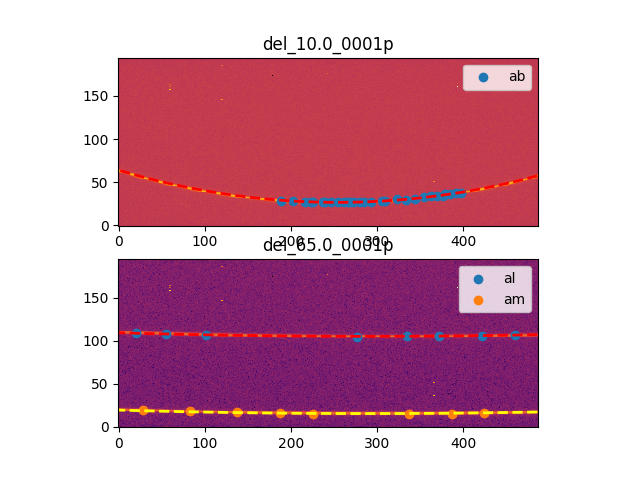

In [21]:
# Check the calibration of the first and the last image with rings

print("First & last rings")

fig = plt.figure()
for idx,lbl in enumerate(["del_10.0_0001p", "del_65.0_0001p"]):
    sg = gonioref.single_geometries[lbl]
    if sg.control_points.get_labels():
        sg.geometry_refinement.set_param(gonioref2.get_ai(sg.get_position()).param)
    jupyter.display(sg=sg, ax=fig.add_subplot(2, 1, idx+1))

MultiGeometry integrator with 121 geometries on (4, 66) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


<IPython.core.display.Javascript object>


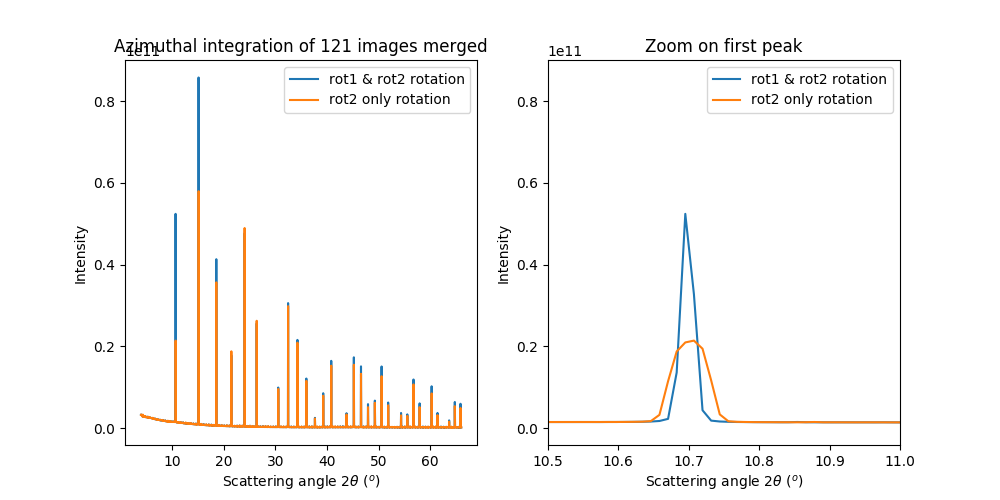

In [22]:
#Create a MultiGeometry integrator from the refined geometry and display the integrated image:

multigeo2 = gonioref2.get_mg(angles)
multigeo2.radial_range=(4, 66)
print(multigeo2)

res2 = multigeo2.integrate1d(images, npt)

#Display the 2 curves with a zoom
fig = figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(*res2, label="rot1 & rot2 rotation")
ax.plot(*res, label="rot2 only rotation")
ax.set_xlabel(res.unit.label)
ax.set_ylabel("Intensity")
ax.set_title("Azimuthal integration of 121 images merged")
ax.legend()
ay = fig.add_subplot(1,2,2)
ay.plot(*res2, label="rot1 & rot2 rotation")
ay.plot(*res, label="rot2 only rotation")
ay.set_xlabel(res.unit.label)
ay.set_ylabel("Intensity")
ay.set_xlim(10.5,11)
ay.set_title("Zoom on first peak")
ay.legend()


With the first model, the refinement was not perfect on the very low angles and indicates a miss-fit. Relaxing the constrains on *rot1* allowed to spot a non (perfect) orthogonality between the goniometer axis and the incident beam. Releasing the distances is also possible, for example to cope with the sample not perfectly mounted on the center of the goniometer. 

## Evaluation of the peak-profile

For every peak, as listed in the calibrant's definition, the peak height can be extracted and the nearest minimum evaluated. The the full width at half maximum can be measured an ploted as function of the scattering angle. 
The FWHM can be fitted against Caglioti's formula: 

FWHM² = U tan² $\theta$ + V tan $\theta$ + W

In [23]:
# Line profile function...
#Peak profile

from scipy.interpolate import interp1d
from scipy.optimize import bisect

def calc_fwhm(integrate_result, calibrant):
    "calculate the tth position and FWHM for each peak"
    delta = integrate_result.intensity[1:] - integrate_result.intensity[:-1]
    maxima = numpy.where(numpy.logical_and(delta[:-1]>0, delta[1:]<0))[0]
    minima = numpy.where(numpy.logical_and(delta[:-1]<0, delta[1:]>0))[0]
    maxima += 1
    minima += 1
    tth = []
    FWHM = []
    for tth_rad in calibrant.get_2th():
        tth_deg = tth_rad*integrate_result.unit.scale
        if (tth_deg<=integrate_result.radial[0]) or (tth_deg>=integrate_result.radial[-1]):
            continue
        idx_theo = abs(integrate_result.radial-tth_deg).argmin()
        id0_max = abs(maxima-idx_theo).argmin()
        id0_min = abs(minima-idx_theo).argmin()
        I_max = integrate_result.intensity[maxima[id0_max]]
        I_min = integrate_result.intensity[minima[id0_min]]
        tth_maxi = integrate_result.radial[maxima[id0_max]]
        I_thres = (I_max + I_min)/2.0
        if minima[id0_min]>maxima[id0_max]:
            if id0_min == 0:
                min_lo = integrate_result.radial[0]
            else:
                min_lo = integrate_result.radial[minima[id0_min-1]]
            min_hi = integrate_result.radial[minima[id0_min]]
        else:
            if id0_min == len(minima) -1:
                min_hi = integrate_result.radial[-1]
            else:
                min_hi = integrate_result.radial[minima[id0_min+1]]
            min_lo = integrate_result.radial[minima[id0_min]]

        f = interp1d(integrate_result.radial, integrate_result.intensity-I_thres)
        tth_lo = bisect(f, min_lo, tth_maxi)
        tth_hi = bisect(f, tth_maxi, min_hi)
        FWHM.append(tth_hi-tth_lo)
        tth.append(tth_deg)
    return tth, FWHM


<IPython.core.display.Javascript object>


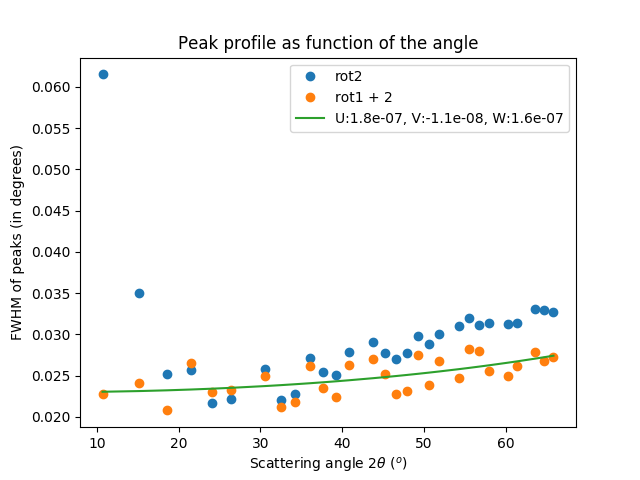

In [24]:
fig, ax = subplots()
ax.plot(*calc_fwhm(res, LaB6), "o", label="rot2")
ax.plot(*calc_fwhm(res2, LaB6), "o", label="rot1 + 2")
# for lbl, sg in gonioref2d.single_geometries.items():
#     ai = gonioref2d.get_ai(sg.get_position())
#     img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
#     res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
#     t,w = calc_fwhm(res, calibrant=calibrant)
#     ax.plot(t, w,"-o", label=lbl)
ax.set_title("Peak profile as function of the angle")
ax.set_ylabel("FWHM of peaks (in degrees)")
ax.set_xlabel(res.unit.label)
ax.legend()

In [25]:
#Fit against Caglioti's formula:
# FWHM^2 = Utan2 + Vtan + W
tth_deg, FWHM_deg = calc_fwhm(res2, LaB6)

def model_Caglioti(tth_deg, U, V, W):
    tantheta = numpy.tan(numpy.deg2rad(tth_deg)/2.0)
    FWHM2 = U*tantheta*tantheta + V*tantheta + W
    return numpy.rad2deg(sqrt(FWHM2))

from scipy.optimize import curve_fit
fit,cov = curve_fit(model_Caglioti, tth_deg, FWHM_deg, p0=[1e-6,1e-7,1e-8])
print(fit)
print(cov)
ax.plot(tth_deg, model_Caglioti(tth_deg, *fit), label="U:%.1e, V:%.1e, W:%.1e"%(fit[0], fit[1], fit[2]))
ax.legend()

[ 1.78018609e-07 -1.05916053e-08  1.61092184e-07]
[[ 4.20844197e-14 -3.16262369e-14  4.92066606e-15]
 [-3.16262369e-14  2.47707384e-14 -4.08398025e-15]
 [ 4.92066606e-15 -4.08398025e-15  7.48147437e-16]]


In [26]:
print("Total execution time: %.3fs"%(time.time() - start_time))

Total execution time: 21.477s


## Conclusion

This notebook exposes the how to calibrate the goniometer for a small detector moving on a 2theta arm. 
Once calibrated, the geometry can be saved and restored and stays valid as long as the detector or the goniometer is not unmounted from the beam-line. This configuration can subsequently be used to integrate the data acquired with any  sample, in minutes instead of hours. The resolution limit is now the pixel size. Fortunately, pixel detector with small pixel like the MaxiPix or the Lambda detector exists and offer higher resolution.